In [1]:
import os
import wrds
import quandl
import zipfile
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.cm as cm
import datetime as dt
pd.options.display.float_format = '{:.6f}'.format

## Helper Functions

In [2]:
BASE_DIR = Path(os.getcwd()).resolve()
DATA_DIR = BASE_DIR / "Data"
print(f'Base Directory: \n {BASE_DIR}')
print(f'Data Directory: \n {DATA_DIR}')

Base Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project
Data Directory: 
 /Users/kaleembukhari/Documents/Kaleem's Data/University of Chicago/GitHubRepositories/TE-Portfolio-Stress-Testing-Final-Project/Data


In [3]:
def get_wrds_data(sql_query, start_date, end_date):

    try:
        db = wrds.Connection()
        formatted_query = sql_query.format(start_date=start_date, end_date=end_date)
        data = db.raw_sql(formatted_query)
        db.close()
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace = True)
        return data

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

def fama_french_regression(factors, portfolio_excess_return):

    X = sm.add_constant(factors)
    Y = portfolio_excess_return
    model = sm.OLS(Y, X, missing='drop').fit()
    print(model.summary())
    results_df = pd.DataFrame({'Coefficient': model.params})
    return results_df

def compute_predictions_with_actual(parameters_df, factors_df, realized_returns, annualizing_factor = 4):
    intercept = parameters_df.loc['const', 'Coefficient'] / annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    predictions = intercept + factors_df @ betas

    prediction_df = pd.DataFrame({'Predicted Returns': predictions}, index=factors_df.index).dropna()
    actual_values = realized_returns
    actual_predict_df = pd.merge(prediction_df, actual_values, 
                                 how = 'inner', left_index = True, right_index = True)
    
    return actual_predict_df

def calculate_OOS_predictions(parameters_df, factors_df, annualizing_factor = 4):
    intercept = parameters_df.loc['const', 'Coefficient'] / annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    predictions = intercept + factors_df @ betas

    prediction_df = pd.DataFrame({'Predicted Returns': predictions}, index=factors_df.index).dropna()
    
    return prediction_df

def print_regression_results(ff_mev_regression_results):

    for factor, result in ff_mev_regression_results.items():
        regression_summary = result[0]
        actual_vs_predicted_df = result[1]
        print(f"Regression Results for {factor} on Historical Data:\n")
        print(regression_summary)
        print("\n" + "="*80 + "\n")

def macroeconomic_fama_french_regression(factors_df, macroecon_vars_df, annualizing_factor = 4):

    mev_reg_res_dict = {}
    params_dict = {}

    features = macroecon_vars_df.copy()
    ff_factors = factors_df.copy()

    X = features
    X = sm.add_constant(X)

    for factor_ in ff_factors.columns:
        y = ff_factors[[factor_]]
        model = sm.OLS(y, X, missing = 'drop').fit()
        
        summary_ = model.summary()
        params_df = pd.DataFrame(model.params, columns = ['Coefficient'])
        
        actual_vs_predicted_ff_df = compute_predictions_with_actual(params_df, features, y, annualizing_factor)
        
        mev_reg_res_dict[f'{factor_}'] = [summary_ , actual_vs_predicted_ff_df]
        params_dict[f'{factor_}'] = params_df
    
    return mev_reg_res_dict, params_dict

## Section 5: Constructing a Generalized Factor Model to stress test portfolio performance

## 5.1. Model Development Plan

### Two-Step Approach
This framework is designed to evaluate the impact of macroeconomic variables on portfolio performance under both normal and stressed economic cycles. To achieve this, we develop two distinct multivariate regression models.

Including macroeconomic variables alongside Fama-French factors in a single model to assess portfolio performance is not ideal due to multicollinearity issues among independent variables. For instance, the Market Factor reflects overall market performance, which is inherently influenced by economic conditions. Correlated explanatory variables violate the assumptions of regression models, compromising robustness.

To address this, we adopt a two-step approach to build a generalized factor model for assessing portfolio performance. This approach will also be used for stress-testing portfolio performance.

### Mechanics of the Two-Step Model Approach:
**Model 1 - Portfolio Returns Factor Model**

Construct a factor model using the Fama-French factors, along with additional factors such as Momentum, Profitability, and Investment. This model assesses the impact of these factors on portfolio performance.

**Model 2 - Factors vs Macroeconomic Varibales**

Develop a second model to analyze the relationship between macroeconomic variables and the individual factors used as independent variables in Model 1. Macroeconomic data will be transformed as necessary to ensure stationarity. Given that some macroeconomic variables have lagging effects on economic outcomes, appropriate lags will be incorporated to capture these dynamics effectively.

### Portfolio Returns and Exposure Calculation
<b>The portfolio return is regressed on factor exposures:</b>

$$R_t - R_f = \alpha + \sum_{i} \beta_i \cdot F_{i,t} + \epsilon_t $$
Where:
- $R_t$: Portfolio return at time $t$
- $R_f$: Risk-free rate
- $\beta_i$: Portfolio exposure to factor $i$
- $F_{i,t}$: Return of Fama French factor $i$ at time $t$
- $\alpha$: Portfolio-specific alpha
- $\epsilon_t$: Residual term


<b>Each factor is modeled as a function of macroeconomic variables:</b>

$$F_{i,t} = \delta_i + \sum_{j} \gamma_{i,j} \cdot M_{j,t} + \eta_{i,t}$$
Where:
- $F_{i,t}$: Return of Fama French factor $i$ at time $t$
- $\delta_i$: Intercept term for factor $i$
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$
- $M_{j,t}$: Macroeconomic variable $j$ at time $t$
- $\eta_{i,t}$: Residual term for factor $i$


<b>Final Prediction for Portfolio Returns:</b>

To forecast portfolio returns, we first generate forecasts for each Fama-French factor ($\hat{F_{i,t}}$) using the macroeconomic variables and the second model. These forecasts are then weighted by the corresponding $\beta_i$ coefficients from Step 1. The predicted portfolio return is calculated as:

$$ \hat{R_t} - R_f = \alpha + \sum_{i} \beta_i \cdot \hat{F_{i,t}} $$

Where:  
- $\hat{F_{i,t}}$: Forecasted return of Fama-French factor $i$ based on macroeconomic variables  
- $\beta_i$: Portfolio exposure to factor $i$ (from Step 1)  
- $\alpha$: Portfolio-specific alpha  

<b>Combined Portfolio Exposure to Macroeconomic Variables:</b>

The contribution of macroeconomic variables to portfolio returns is given by:

$$ \text{Portfolio Exposure} = \sum_{i} \beta_i \cdot \gamma_{i,j} $$

Where:  
- $\beta_i$: Portfolio exposure to factor $i$ (from Step 1)  
- $\gamma_{i,j}$: Sensitivity of factor $i$ to macroeconomic variable $j$ (from Step 2)  

### Querying Fama-French Factors from WRDS
- <b> Note:</b> We have used the following query to download data from WRDS directly instead of using the 'wrds_data.xlsx' file. The query allowed us to download all 6 factors in a single run

In [4]:
# Fama French Sql Query
fama_french_sql_query = """
            SELECT date, 
                   mktrf AS MKT, 
                   smb AS SMB, 
                   hml AS HML,
                   rmw AS PROFT,
                   cma AS INVST,
                   rf AS RFR,
                   umd AS MMNTM
            FROM ff_all.fivefactors_monthly
            WHERE date BETWEEN '{start_date}' AND '{end_date}'
            ORDER BY date;
            """

In [5]:
start_date = '1991-12-01'
end_date = '2024-12-31'
ff_6_factors = get_wrds_data(fama_french_sql_query, start_date, end_date)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [6]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-01,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-01-01,-0.005900,0.091800,0.047100,-0.013200,0.032000,0.003400,-0.024900
1992-02-01,0.010900,0.013300,0.064700,0.000800,0.021900,0.002800,-0.005300
1992-03-01,-0.026600,-0.009300,0.035600,-0.000100,0.019500,0.003400,-0.002900
1992-04-01,0.010700,-0.057000,0.043400,0.016900,0.022300,0.003200,-0.025800


### Saving Fama-French 5 Factors plus Momentum Data
- Data type: Returns
- Frequency: Monthly resample to Quarterly

In [7]:
ff_6_factors = ff_6_factors.resample('QE').mean()
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-31,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-03-31,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033
1992-06-30,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833
1992-09-30,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467
1992-12-31,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133


In [8]:
ff_6_factors_file = 'ff_6_factors.csv'
ff_6_factors.to_csv(DATA_DIR/ff_6_factors_file, index = True)

In [9]:
ff_6_factors.head()

,mkt,smb,hml,proft,invst,rfr,mmntm
date,,,,,,,
1991-12-31,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-03-31,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033
1992-06-30,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833
1992-09-30,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467
1992-12-31,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133


### Getting weighted portfolio returns

In [10]:
portfolio_file_ = 'final_portfolio_returns.csv'
prtf_rets = pd.read_csv(DATA_DIR/portfolio_file_)
prtf_rets['Date'] = pd.to_datetime(prtf_rets['Date'])
prtf_rets.set_index('Date', inplace = True)
prtf_rets.head()

,EW Portfolio Returns Excess,EF Portfolio Returns Excess
Date,,
1991-12-31,0.039932,0.017411
1992-03-31,-0.014570,0.003242
1992-06-30,-0.013064,-0.023189
1992-09-30,0.009963,0.007282
1992-12-31,0.028616,0.029271


In [11]:
analysis_start_date = prtf_rets.index.min()

In [12]:
prtfs_rets_ff_fctr = pd.merge(prtf_rets, ff_6_factors, 
                              how = 'inner', left_index = True, right_index = True)
prtfs_rets_ff_fctr.head()

,EW Portfolio Returns Excess,EF Portfolio Returns Excess,mkt,smb,hml,proft,invst,rfr,mmntm
1991-12-31,0.039932,0.017411,0.108400,-0.024000,-0.041700,0.035500,-0.031200,0.003800,0.081900
1992-03-31,-0.014570,0.003242,-0.007200,0.031933,0.049133,-0.004167,0.024467,0.003200,-0.011033
1992-06-30,-0.013064,-0.023189,-0.003233,-0.027400,0.029233,0.002300,0.012400,0.003067,-0.009833
1992-09-30,0.009963,0.007282,0.008600,-0.001867,-0.006400,0.022200,-0.010500,0.002767,0.008467
1992-12-31,0.028616,0.029271,0.022267,0.025633,-0.002367,0.000267,-0.005133,0.002467,0.022133


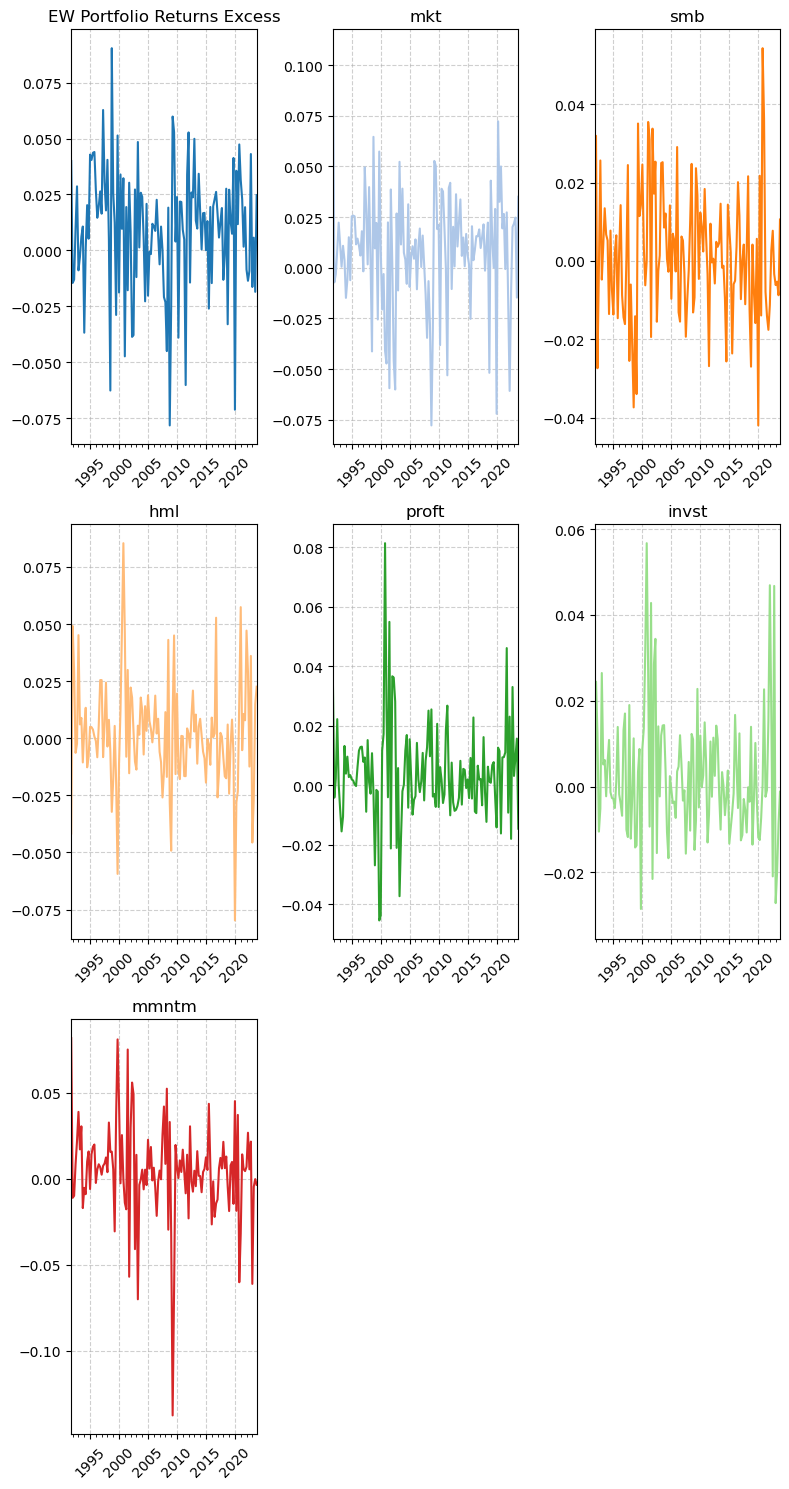

In [28]:
vars_to_plot = ['EW Portfolio Returns Excess', 'mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']
n_cols = 3
n_rows = (len(vars_to_plot) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 5 * n_rows))
axes = axes.flatten()

colors = cm.tab20.colors

for i, var_ in enumerate(vars_to_plot):
    color = colors[i % len(colors)]
    prtfs_rets_ff_fctr[var_].plot(ax=axes[i], color=color)
    axes[i].set_title(var_)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.6)

for j in range(len(vars_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Section 5.2

In this section, we are reporting the model results from Section 4 in order to compare them with the results we get from the models built in Section 5, the cell below gives the summary of the results from Section 4 of the historical data driven regressions. Later in section 5.3, where we display the results of the regression model for 6 fama french factors using macroeconomic variables and present our analysis

<b><I>Analysis from Section 4</b></I>

The regression results for the Market Factor (Rm-Rf) show that the model explains 22.4% of the variability (R-squared = 0.224, p < 0.0001). Significant predictors include the Market Volatility Index (coefficient = -0.0010, p < 0.0001) and the Unemployment rate (coefficient = 0.0044, p = 0.001), suggesting that higher market volatility negatively impacts the market factor while higher unemployment positively influences it. Other variables, such as CPI inflation, Real GDP growth, and Treasury yields, were not statistically significant, indicating limited explanatory power for these factors in driving the market premium.

For the Size Factor (SMB), the model explains 13.0% of the variability (R-squared = 0.130, p = 0.008). Significant contributors include the Unemployment rate (coefficient = 0.0019, p = 0.018), 3-month Treasury rate (coefficient = -0.0078, p = 0.040), and 10-year Treasury yield (coefficient = 0.0128, p = 0.002). The results indicate that an increase in unemployment positively impacts SMB, while short-term rates negatively impact it. Long-term Treasury yields, however, have a positive influence, reflecting complex dynamics in how size premiums are affected by interest rate movements.

The regression for the Value Factor (HML) explains only 7.2% of the variability (R-squared = 0.072, p = 0.162), indicating limited model fit. Among the predictors, only the Market Volatility Index shows significance (coefficient = -0.0004, p = 0.019), suggesting a negative relationship with HML. Other variables, such as unemployment, inflation, GDP growth, and Treasury rates, were not statistically significant. The low explanatory power for HML highlights the potential need for additional variables or non-linear relationships to better capture its behavior. Overall, the results emphasize the influence of volatility and unemployment across all factors, with size and market premiums showing stronger linkages to economic variables than value premiums.

---

## Section 5.3: Comparing Model Results and Projects

## Model 1: Portfolio Returns Prediction with Fama French Factors

| **Category**        | **Variable**       | 
|---------------------|--------------------|
|Dependent Variable   | Portfolio Excess Returns|
|Independent Variable   | MKT                |
|Independent Variable	  |SMB                 |
|Independent Variable	  |HML                 |
|Independent Variable	  |Profitability       |
|Independent Variable   |Investment          |
|Independent Variable	  |Momentum            |

In [14]:
factors_df = prtfs_rets_ff_fctr[['mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']]
prtf_exs_rets_df = prtfs_rets_ff_fctr[['EW Portfolio Returns Excess']]

### Regression Summary for Portfolio Returns

In [15]:
portfolio_returns_ff_factors_regression = fama_french_regression(factors_df, prtf_exs_rets_df)

                                 OLS Regression Results                                
Dep. Variable:     EW Portfolio Returns Excess   R-squared:                       0.726
Model:                                     OLS   Adj. R-squared:                  0.713
Method:                          Least Squares   F-statistic:                     53.93
Date:                         Wed, 20 Nov 2024   Prob (F-statistic):           5.02e-32
Time:                                 17:11:43   Log-Likelihood:                 363.04
No. Observations:                          129   AIC:                            -712.1
Df Residuals:                              122   BIC:                            -692.1
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The six-factor Fama-French model explains sligthtly less variability in portfolio returns (R-squared = 72.6%) as compared to the three-factor Fama-French model that explains slightly more variability in portfolio returns (R-squared = 74.1%), indicating that adding the Profitability, Investment, and Momentum factors does not significantly improve explanatory power. 

The market factor (MKT) remains the most significant driver of portfolio returns in both models, with consistent coefficients and high statistical significance (p < 0.0001). 

The size factor (SMB) is significant and negatively related to returns in the three-factor model (p = 0.016) but loses significance in the six-factor model (p = 0.132), possibly due to correlations with additional factors. 

The value factor (HML) is consistently significant in both models, showing a positive relationship with portfolio returns. 

However, the added factors such Profitability, Investment, and Momentum are not statistically significant, contributing little to the model. Overall, the three-factor model provides a slightly better fit with fewer variables, maintaining robust explanatory power.

### Computing In-Sample Portfolio Excess Returns as a function of Fama French Fators 

In [16]:
portf_ff_regression_returns = compute_predictions_with_actual(portfolio_returns_ff_factors_regression, factors_df, prtf_exs_rets_df,4)
portf_ff_regression_returns['Cumulative Actual Returns'] = (1 + portf_ff_regression_returns['EW Portfolio Returns Excess']).cumprod() - 1
portf_ff_regression_returns['Cumulative Predicted Returns'] = (1 + portf_ff_regression_returns['Predicted Returns']).cumprod() - 1
portf_ff_regression_returns.head()

,Predicted Returns,EW Portfolio Returns Excess,Cumulative Actual Returns,Cumulative Predicted Returns
1991-12-31,0.072049,0.039932,0.039932,0.072049
1992-03-31,0.006557,-0.014570,0.024780,0.079079
1992-06-30,0.011413,-0.013064,0.011392,0.091394
1992-09-30,0.004130,0.009963,0.021469,0.095902
1992-12-31,0.012457,0.028616,0.050699,0.109554


## Plotting Portfolio Returns Predictions

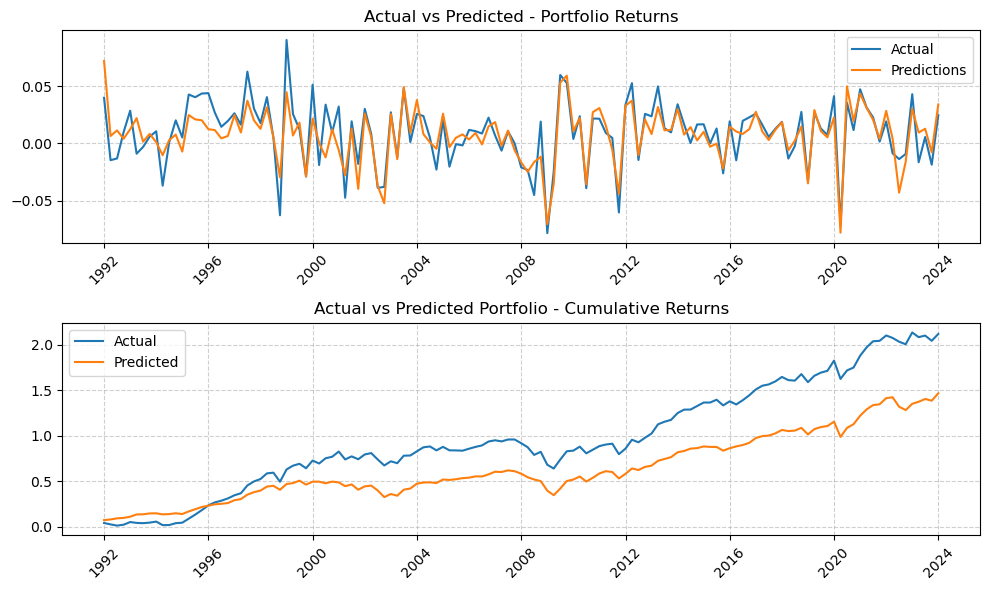

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Plot 1: Actual vs Predicted - Portfolio Returns
axes[0].plot(portf_ff_regression_returns.index, portf_ff_regression_returns['EW Portfolio Returns Excess'], label='Actual')
axes[0].plot(portf_ff_regression_returns.index, portf_ff_regression_returns['Predicted Returns'], label='Predictions')
axes[0].set_title("Actual vs Predicted - Portfolio Returns")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Actual vs Predicted - Cumulative Returns
axes[1].plot(portf_ff_regression_returns.index, portf_ff_regression_returns['Cumulative Actual Returns'], label='Actual')
axes[1].plot(portf_ff_regression_returns.index, portf_ff_regression_returns['Cumulative Predicted Returns'], label='Predicted')
axes[1].set_title("Actual vs Predicted Portfolio - Cumulative Returns")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Model 2: Fama French Factors Returns Prediction using Macroeconomic Variables

| **Category**        | **Variable**       |
|---------------------|--------------------|
| Dependent Variable  | MKT                |
|Dependent Variable	  |SMB                 |
|Dependent Variable	  |HML                 |
|Dependent Variable	  |Profitability       |
|Dependent Variable   |Investment          |
|Dependent Variable	  |Momentum            |
|Independent Variable |Market Volatility   |
|Independent Variable |Unemployment Rate   |
|Independent Variable |CPI Inflation Rate|
|Independent Variable |Real GDP            |
|Independent Variable |3-Month US Treasury |
|Independent Variable |10-Year US Treasury |


## Reading macroeconomic variables data

In [18]:
historic_mev_file_ = "2024-Table_2A_Historic_Domestic.csv"
baseline_mev_file_ = "2024-Table_3A_Supervisory_Baseline_Domestic.csv"
severe_mev_file_ = "2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv"

mev_variables = ['Date', 'Market Volatility Index (Level)','Real GDP growth', 'Unemployment rate', 
                 'CPI inflation rate','3-month Treasury rate','10-year Treasury yield']

In [19]:
historic_mev_data = pd.read_csv(DATA_DIR/historic_mev_file_, usecols = mev_variables)
historic_mev_data['Date'] = pd.to_datetime(historic_mev_data['Date'])
historic_mev_data = historic_mev_data[historic_mev_data['Date'] >= analysis_start_date]
historic_mev_data.set_index('Date', inplace = True)

baseline_mev_data = pd.read_csv(DATA_DIR/baseline_mev_file_, usecols = mev_variables)
baseline_mev_data['Date'] = pd.to_datetime(baseline_mev_data['Date'])
baseline_mev_data.set_index('Date', inplace = True)

severe_mev_data = pd.read_csv(DATA_DIR/severe_mev_file_, usecols = mev_variables)
severe_mev_data['Date'] = pd.to_datetime(severe_mev_data['Date'])
severe_mev_data.set_index('Date', inplace = True)

#### Running Regression and printing Summary for each Fama French Factor Regression

In [20]:
factors_df = prtfs_rets_ff_fctr[['mkt', 'smb', 'hml', 'proft', 'invst', 'mmntm']]

ff_6_fctrs_mev_reg_results, ff_6_fac_mev_coeffs_ = macroeconomic_fama_french_regression(factors_df, historic_mev_data, annualizing_factor = 4)

In [21]:
print_regression_results(ff_6_fctrs_mev_reg_results)

Regression Results for mkt on Historical Data:

                            OLS Regression Results                            
Dep. Variable:                    mkt   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     7.707
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           4.91e-07
Time:                        17:11:43   Log-Likelihood:                 294.18
No. Observations:                 129   AIC:                            -574.4
Df Residuals:                     122   BIC:                            -554.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

The comparison of the regression results for the three-factor and six-factor models highlights subtle differences in the relationships between macroeconomic variables and the Fama-French factors. 

In the three-factor model, the Market Volatility Index and Unemployment Rate were highly significant predictors, especially for the Market Factor (Rm-Rf) (coefficients: -0.0010 and 0.0044, respectively), explaining 22.4% of the variability (R-squared = 0.224). For the Size Factor (SMB), short-term interest rates negatively impacted returns, while long-term rates had a positive influence. The explanatory power for Value (HML) was minimal, with only Market Volatility showing significance.

In the six-factor model, the Market Volatility Index remained a strong predictor for the Market and Value factors, with the latter showing improved fit (R-squared = 0.119). However, the model's ability to explain Size (SMB) declined (R-squared = 0.071), and newer factors such as Profitability (RMW) and Momentum (MOM) showed weak relationships with macroeconomic variables (R-squared of 0.038 and 0.075, respectively). 

Interestingly, the Investment Factor (CMA) exhibited marginal significance with CPI inflation rates. While the six-factor model marginally improved the explanation of Market and Value returns, it revealed the limitations of macroeconomic variables in capturing the dynamics of newer factors, suggesting the need for additional predictors or alternative modeling approaches.

## Two-Step Factor Model Predictions

<b>Final Prediction for Portfolio Returns Methdology</b>

In order to make Out of Sample forecats for the period starting from 2024-Q1 till till end of 2025, we use a weighted approach. We first generate forecasts for each Fama-French factor ($\hat{F_{i,t}}$) using the macroeconomic variables using Model 2. These forecasts are then weighted by the corresponding $\beta_i$ coefficients of each Fama French Factor from Model 1. The predicted portfolio return is calculated as:

$$ \hat{R_t} - R_f = \alpha + \sum_{i} \beta_i \cdot \hat{F_{i,t}} $$

Where:  
- $\hat{F_{i,t}}$: Forecasted return of Fama-French factor $i$ based on macroeconomic variables (from Model 2) 
- $\beta_i$: Portfolio exposure to factor $i$ (from Model 1)  
- $\alpha$: Portfolio-specific alpha  

In [24]:
fctr_pred_with_mev_baseline = {}
fctr_pred_with_mev_adverse = {}

for fctr in ff_6_fac_mev_coeffs_.keys():
    coeff_mev = ff_6_fac_mev_coeffs_[fctr]

    mev_base_pred = calculate_OOS_predictions(coeff_mev, baseline_mev_data, 4)
    fctr_pred_with_mev_baseline[fctr] = mev_base_pred

    mev_adverse_pred = calculate_OOS_predictions(coeff_mev, severe_mev_data, 4)
    fctr_pred_with_mev_adverse[fctr] = mev_adverse_pred

fctr_pred_with_mev_baseline_df = pd.DataFrame({fctr: pred.squeeze() for fctr, pred in fctr_pred_with_mev_baseline.items()})
fctr_pred_with_mev_baseline_df.rename(columns = {'Predicted Returns':'Baseline Predicted Returns'}, inplace = True)

fctr_pred_with_mev_adverse_df = pd.DataFrame({fctr: pred.squeeze() for fctr, pred in fctr_pred_with_mev_adverse.items()})
fctr_pred_with_mev_adverse_df.rename(columns = {'Predicted Returns':'Adverse Predicted Returns'})

,mkt,smb,hml,proft,invst,mmntm
Date,,,,,,
2024-03-31,-0.028341,-0.009270,-0.009841,0.018208,0.010346,-0.006018
2024-06-30,-0.031983,-0.008163,-0.014611,0.017551,0.010149,-0.003509
2024-09-30,-0.014560,-0.004050,-0.011237,0.015610,0.008478,-0.009869
2024-12-31,0.001825,-0.001843,-0.010032,0.014083,0.006399,-0.013293
2025-03-31,0.012505,-0.001113,-0.010044,0.012839,0.004632,-0.012991
2025-06-30,0.019061,-0.000427,-0.009728,0.011790,0.003482,-0.012667
2025-09-30,0.022744,0.000587,-0.008540,0.011077,0.003064,-0.013107
2025-12-31,0.024089,-0.000868,-0.010396,0.010199,0.001793,-0.008457
2026-03-31,0.021894,-0.000503,-0.009203,0.009678,0.002007,-0.007385


In [25]:
last_value = portf_ff_regression_returns['Cumulative Actual Returns'].iloc[-1]

In [26]:
final_portfolio_rets_pred_baseline_mev = calculate_OOS_predictions(portfolio_returns_ff_factors_regression, fctr_pred_with_mev_baseline_df, 1)
final_portfolio_rets_pred_adverse_mev = calculate_OOS_predictions(portfolio_returns_ff_factors_regression, fctr_pred_with_mev_adverse_df, 1)
final_portfolio_rets_pred = pd.merge(final_portfolio_rets_pred_baseline_mev, final_portfolio_rets_pred_adverse_mev, how = 'inner', left_index=True, right_index=True)
final_portfolio_rets_pred['Cumulative Returns - Baseline'] = last_value + (final_portfolio_rets_pred['Predicted Returns_x']).cumsum()
final_portfolio_rets_pred['Cumulative Returns - Adverse'] = last_value + (final_portfolio_rets_pred['Predicted Returns_y']).cumsum()
final_portfolio_rets_pred = final_portfolio_rets_pred.iloc[:5,]
final_portfolio_rets_pred

,Predicted Returns_x,Predicted Returns_y,Cumulative Returns - Baseline,Cumulative Returns - Adverse
Date,,,,
2024-03-31,0.010216,-0.020487,2.128810,2.098106
2024-06-30,0.009016,-0.025058,2.137826,2.073048
2024-09-30,0.007356,-0.010094,2.145182,2.062954
2024-12-31,0.006180,0.003447,2.151361,2.066402
2025-03-31,0.004951,0.011923,2.156312,2.078325


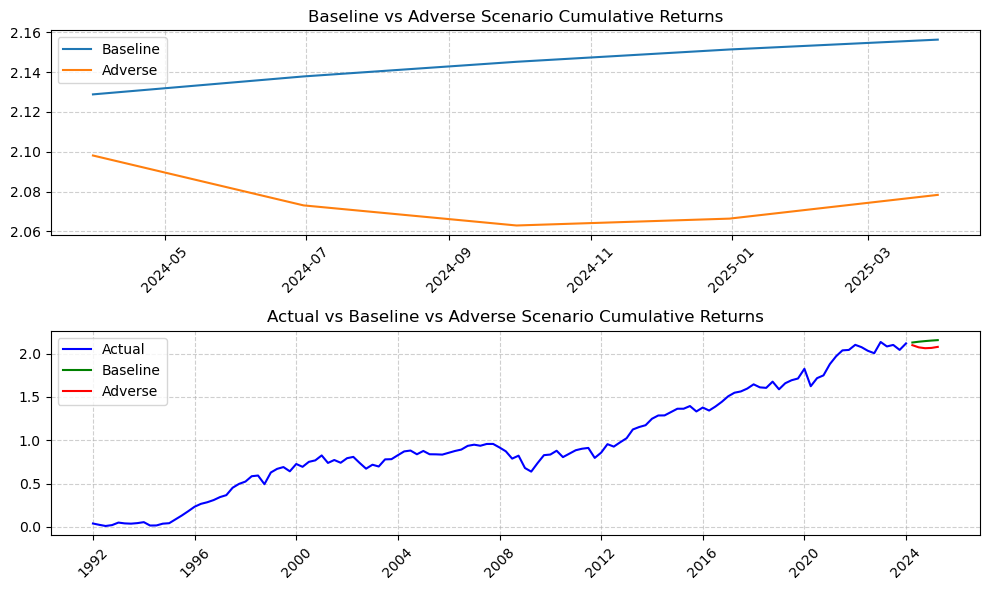

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(final_portfolio_rets_pred.index, 
             final_portfolio_rets_pred['Cumulative Returns - Baseline'], label='Baseline')
axes[0].plot(final_portfolio_rets_pred.index, 
             final_portfolio_rets_pred['Cumulative Returns - Adverse'], label='Adverse')
axes[0].set_title("Baseline vs Adverse Scenario Cumulative Returns")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(portf_ff_regression_returns.index, 
             portf_ff_regression_returns['Cumulative Actual Returns'], label='Actual', color='blue')
axes[1].plot(final_portfolio_rets_pred.index, 
             final_portfolio_rets_pred['Cumulative Returns - Baseline'], label='Baseline', color='green')
axes[1].plot(final_portfolio_rets_pred.index, 
             final_portfolio_rets_pred['Cumulative Returns - Adverse'], label='Adverse', color='red')

axes[1].set_title("Actual vs Baseline vs Adverse Scenario Cumulative Returns")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()